<a href="https://colab.research.google.com/github/Ibinmbiju/mmm_lightweight_media/blob/main/mmm_lightweight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
pip install lightweight_mmm

  Using cached jax-0.5.0-py3-none-any.whl.metadata (22 kB)
  Using cached jaxlib-0.5.0-cp311-cp311-manylinux2014_x86_64.whl.metadata (978 bytes)
Using cached jax-0.5.0-py3-none-any.whl (2.3 MB)
Using cached jaxlib-0.5.0-cp311-cp311-manylinux2014_x86_64.whl (102.0 MB)
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.20
    Uninstalling jaxlib-0.4.20:
      Successfully uninstalled jaxlib-0.4.20
  Attempting uninstall: jax
    Found existing installation: jax 0.4.20
    Uninstalling jax-0.4.20:
      Successfully uninstalled jax-0.4.20


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

In [2]:
data = pd.read_csv('/content/Advertising Budget and Sales.csv')
data.head()

,Unnamed: 0,TV Ad Budget ($),Radio Ad Budget ($),Newspaper Ad Budget ($),Sales ($)
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [3]:
df=data.drop('Unnamed: 0',axis=1)
df.head()

,TV Ad Budget ($),Radio Ad Budget ($),Newspaper Ad Budget ($),Sales ($)
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [19]:
df.dtypes

,0
TV Ad Budget ($),float64
Radio Ad Budget ($),float64
Newspaper Ad Budget ($),float64
Sales ($),float64


In [4]:
media_data=df[['TV Ad Budget ($)','Radio Ad Budget ($)','Newspaper Ad Budget ($)']].to_numpy()
target_data=df[['Sales ($)']].to_numpy()
#costs=df[['TV Ad Budget ($)','Radio Ad Budget ($)','Newspaper Ad Budget ($)']].sum().to_numpy()

In [5]:
#costs.shape

(3,)

In [6]:
data_size=media_data.shape[0]

In [28]:
split_point=80
media_train=media_data[:split_point]
media_test=media_data[split_point:]
target_train=target_data[:split_point]
costs=media_train.mean(axis=0)

In [36]:
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean, multiply_by=0.15)

media_data_train = media_scaler.fit_transform(media_train)
target_train = target_scaler.fit_transform(target_train)
costs2 = cost_scaler.fit_transform(costs)

In [37]:
print(media_data_train.shape)
print(target_train.shape)
print(costs2.shape)

(80, 3)
(80, 1)
(3,)


In [38]:
media_data_train.shape

(80, 3)

**Training Model**

In [39]:
mmm = lightweight_mmm.LightweightMMM(model_name="carryover")

In [23]:
import jax.numpy as jnp

def apply_exponent_safe(data, exponent):
    print("Inside redefined apply_exponent_safe function!")
    exponent_safe = jnp.where((data == 0), 1, data) ** exponent
    return jnp.where((data == 0), 0, exponent_safe)

In [40]:
number_warmup=100
number_samples=100

In [44]:
mmm.fit(
    media=media_data_train,
    media_prior=costs2,
    target=target_train,
    number_warmup=number_warmup,
    number_samples=number_samples,
    number_chains=1
    )

sample: 100%|██████████| 200/200 [00:13<00:00, 15.24it/s, 1023 steps of size 3.15e-03. acc. prob=0.99]


In [45]:
mmm.print_summary()


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
ad_effect_retention_rate[0]      0.27      0.14      0.24      0.09      0.50      7.22      1.12
ad_effect_retention_rate[1]      0.50      0.25      0.57      0.10      0.80      3.83      1.54
ad_effect_retention_rate[2]      0.74      0.10      0.76      0.58      0.87      6.98      1.03
              coef_media[0]      0.01      0.01      0.01      0.00      0.02     36.30      1.08
              coef_media[1]      0.01      0.01      0.01      0.00      0.02      7.18      1.17
              coef_media[2]      0.01      0.01      0.01      0.00      0.02      6.23      1.04
              coef_trend[0]     -0.00      0.00      0.00     -0.00      0.00     73.00      1.01
                 expo_trend      0.72      0.12      0.74      0.56      0.88      3.21      2.59
                exponent[0]      0.85      0.10      0.87      0.68      0.98      5.31      1.57
                exp

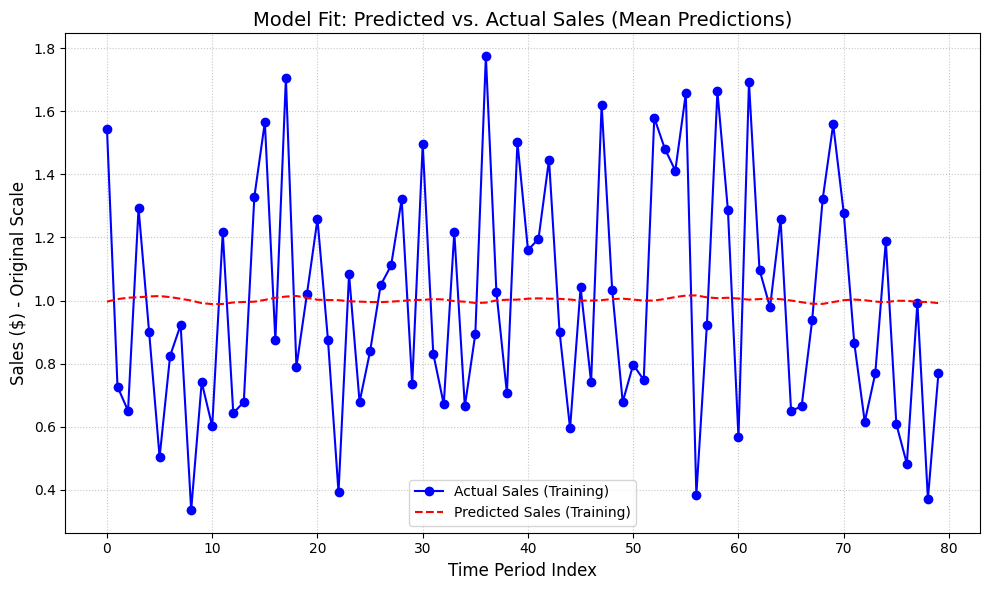

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# 1. GENERATE PREDICTIONS:
prediction_train = mmm.predict(media=media_data_train, target_scaler=target_scaler)

prediction_train_np = np.array(prediction_train)

#  Aggregate predictions by taking the MEAN across samples
mean_prediction_train_np = np.mean(prediction_train_np, axis=0).flatten() # Mean over sample axis (axis=0)
target_train_np = np.array(target_train).flatten() # Flatten target_train

plt.figure(figsize=(10, 6))


time_periods_train = range(len(target_train_np)) # Explicitly create x-values (time period index)


if 'target_scaler' in locals():
    target_train_original_scale = target_scaler.inverse_transform(target_train_np.reshape(-1, 1)).flatten()
    prediction_train_original_scale = target_scaler.inverse_transform(mean_prediction_train_np.reshape(-1, 1)).flatten()
else:
    target_train_original_scale = target_train_np
    prediction_train_original_scale = mean_prediction_train_np


# Plot Training Data - using TIME_PERIODS_TRAIN as X-values and potentially original scale
plt.plot(time_periods_train, target_train_original_scale, label='Actual Sales (Training)', color='blue', marker='o', linestyle='-')
plt.plot(time_periods_train, prediction_train_original_scale, label='Predicted Sales (Training)', color='red', linestyle='--')


plt.title('Model Fit: Predicted vs. Actual Sales (Mean Predictions)', fontsize=14)
plt.xlabel('Time Period Index', fontsize=12)
plt.ylabel('Sales ($) - Original Scale', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

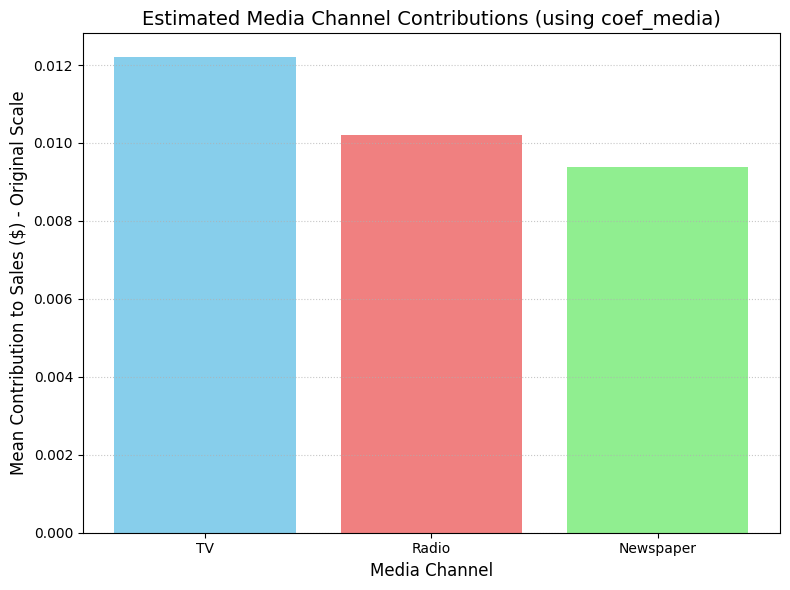

In [75]:
import matplotlib.pyplot as plt
import numpy as np


media_names = ['TV', 'Radio', 'Newspaper']


media_coefficients_samples = mmm.trace['coef_media']
mean_media_coefficients = np.mean(media_coefficients_samples, axis=0) # Average over samples

if 'target_scaler' in locals():
    mean_media_effects_original_scale = target_scaler.inverse_transform(mean_media_coefficients) # Inverse transform coefficients
else:
    mean_media_effects_original_scale = mean_media_coefficients

plt.figure(figsize=(8, 6))
colors = ['skyblue', 'lightcoral', 'lightgreen']
bars = plt.bar(media_names, mean_media_effects_original_scale.flatten(), color=colors)


plt.title('Estimated Media Channel Contributions (using coef_media)', fontsize=14)
plt.xlabel('Media Channel', fontsize=12)
plt.ylabel('Mean Contribution to Sales ($) - Original Scale', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

In [73]:
print(mmm.trace.keys())

dict_keys(['ad_effect_retention_rate', 'coef_media', 'coef_trend', 'expo_trend', 'exponent', 'gamma_seasonality', 'intercept', 'media_transformed', 'mu', 'peak_effect_delay', 'sigma'])
